## Step1. 검증용 데이터셋 준비

In [3]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### 1. Google OCR API

In [4]:
import os
 
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/movie'
file_list = os.listdir(img_dir)
file_list

['movie4.png', 'movie2.png', 'movie3.png', 'movie5.png', 'movie1.png']

In [5]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [6]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(img_dir, file))
    print()

[movie4.png]
Texts:

"CHRIS
NATALIE
TOM
ANTHONY
FROM THE STUDIO THAT BROUGHT YOU "IRON MAN"
HEMSWORTH PORTMAN HIDDLESTON Ano HOPKINS cO
THOR
MARVEL
COURAGEIS IMMORTAL
THE D ARK W ORLD
Tw COMING
IN DIGITAL D AND IMAX 33D ALSO IN 2D IN SELECTED THEATRES
11.8.13
"

"CHRIS"

"NATALIE"

"TOM"

"ANTHONY"

"FROM"

"THE"

"STUDIO"

"THAT"

"BROUGHT"

"YOU"

""IRON"

"MAN""

"HEMSWORTH"

"PORTMAN"

"HIDDLESTON"

"Ano"

"HOPKINS"

"cO"

"THOR"

"MARVEL"

"COURAGEIS"

"IMMORTAL"

"THE"

"D"

"ARK"

"W"

"ORLD"

"Tw"

"COMING"

"IN"

"DIGITAL"

"D"

"AND"

"IMAX"

"33D"

"ALSO"

"IN"

"2D"

"IN"

"SELECTED"

"THEATRES"

"11.8.13"
bounds: (541,486),(583,486),(583,492),(541,492)

[movie2.png]
Texts:

"OUNITE
TILM
MIKKELSEN SWINTON
MAD
CUMBERBATCH ELIOTOR MADAMS
DOCTOR
STRANGE
THE IMPOSU Ti AR ENDIESK
NOVEMBER4
REALD 2D AND IMAX 30
"

"OUNITE"

"TILM"

"MIKKELSEN"

"SWINTON"

"MAD"

"CUMBERBATCH"

"ELIOTOR"

"MADAMS"

"DOCTOR"

"STRANGE"

"THE"

"IMPOSU"

"Ti"

"AR"

"ENDIESK"

"NOVEMBER4"

"REALD"



### 2. keras-ocr

In [7]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [8]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

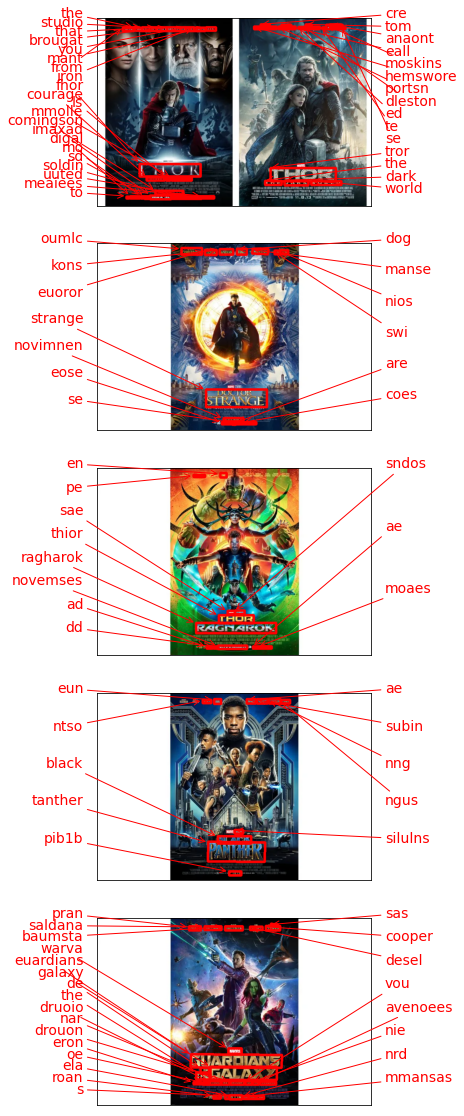

In [9]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 3. Tesseract

In [12]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [13]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_cropped'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(img_dir, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[movie4.png]

Done
[movie2.png]
ae

Bieler 7G) ik

!

Done
[movie3.png]
te -(einl lle).


Done
[movie5.png]
ce

Done
[movie1.png]

Done


### 결과

- Google OCR API: 실제로 포스터에 문자들을 잘 인식해냈다. 가장 정확한 인식률을 보여준 것 같다.
- keras-ocr: 문자를 인식하는 영역은 가시적으로 잘 보였으나 인식한 단어들이 조금 google ocr api보다는 낮은 경향을 보였다.
- Tesseract: 코딩에 문제가 있었나 싶을 정도로 인식률이 떨어졌다. tesseract를 잘 활용할 수 있는 방안에 대해서는 좀더 고민을 해야될 것 같다.

### 느낀점 
이번 노드는 진행하는데에는 어려움이 별로 없어서 비교적 수월하게 진행한 것 같다. 실제로 이미 일상생활에 많이 쓰이는 기술이라서 좀 친근한 느낌도 있었고 cv쪽 중에서도 정말 사회전반적으로 쓰일 수 있는 기술이라서 이미 상용화가 되어 있기 때문인지는 몰라도 기본적인 모델도 굉장히 좋은 인식률을 보여주었다. 아지트에 올라온 보이저엑스라는 라는 회사도 이런류의 기술을 사용하는 것 같았는데 앞으로 매우 유망한 모델인 것 같다. 인식률을 높이는 방법에 대해서는 좀더 깊은 고찰이 필요할 듯 싶다.